In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [2]:
sub = xr.open_dataset('../data/netcdfs/banner_lowman_05208_21019-019_21021-007_0006d.nc')

In [3]:
sub

<xarray.Dataset>
Dimensions:           (x: 3661, y: 6306)
Dimensions without coordinates: x, y
Data variables: (12/37)
    VV-int-imaginary  (x, y) float32 ...
    inc               (x, y) float32 ...
    HV-int-real       (x, y) float32 ...
    HH-int-imaginary  (x, y) float32 ...
    HH-amp2           (x, y) float32 ...
    HH-amp1           (x, y) float32 ...
    ...                ...
    lithography       (x, y) int8 ...
    focal_var         (x, y) float64 ...
    ppt_total         (x, y) float64 ...
    tmean             (x, y) float64 ...
    mean_af_days      (x, y) float64 ...
    max_af_days       (x, y) float64 ...
Attributes: (12/235)
    uavsar rpi annotation file version number:       2.3 -
    site description:                                Lowman, CO
    flight plan comments of pass 1:                  nan
    flight plan comments of pass 2:                  nan
    processing comments:                             nan
    url:                                             http://uavsar.jpl.nasa.g...
    ...                                              ...
    slt_phs.dsp_cmap:                                cmy
    grd_phs.dsp_cmap:                                cmy
    slc_phs.dsp_cmap:                                cmy
    set_hddr:                                        0 bytes
    set_tail:                                        0 bytes
    subset_coords:                                   [-115.6    44.   -115.2 ...

/home/zacharykeskinen/anaconda3/envs/uavsar/lib/python3.8/site-packages/xarray/core/computation.py:742: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


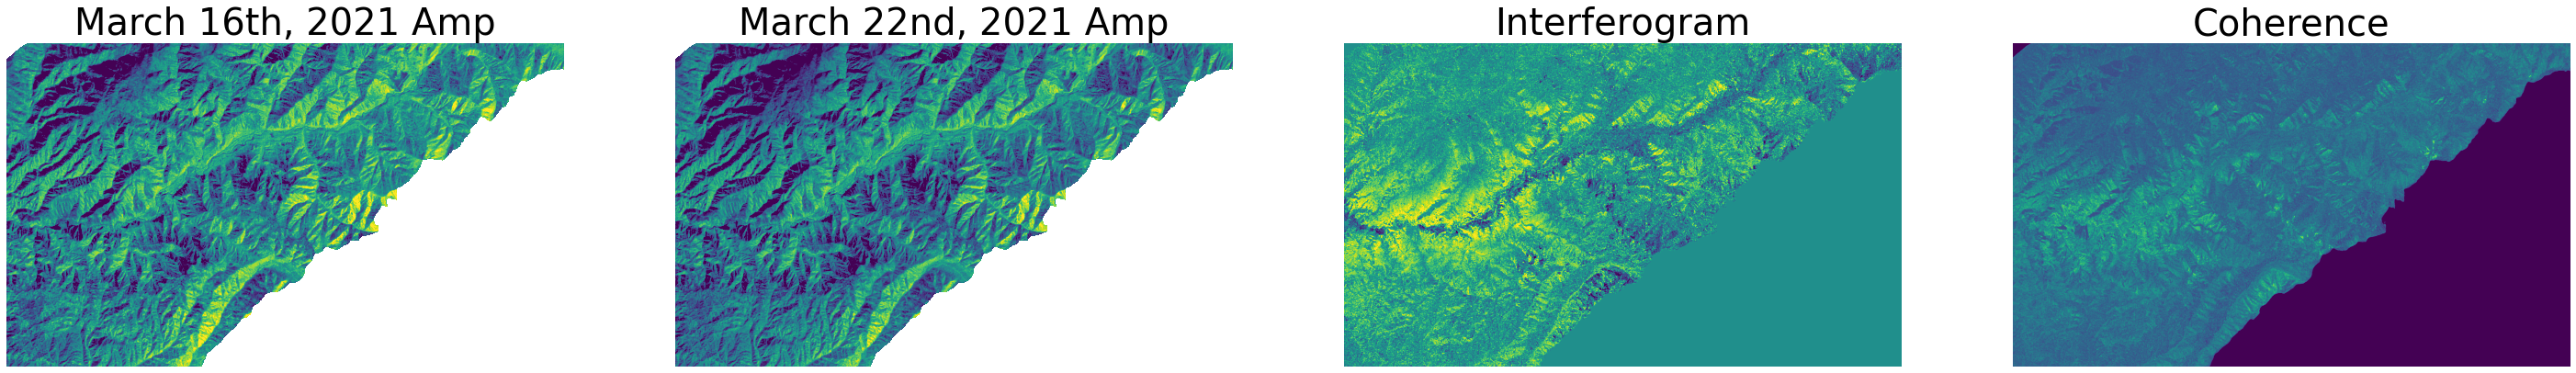

In [4]:
fig,axes = plt.subplots(1,4, figsize = (50,16))
axes[0].imshow(10*np.log(sub['VH-amp1']), vmax = -5, vmin = -30, aspect = 1)
axes[1].imshow(10*np.log(sub['VH-amp2']), vmax = -5, vmin = -30, aspect = 1)

c = np.arctan(np.divide(sub['VH-int-imaginary'], sub['VH-int-real'], out = np.zeros_like(sub['VH-int-imaginary']), where = sub['VH-int-real'] != 0))

im = axes[2].imshow(c,vmax = 1, vmin = -1, aspect = 1)
axes[3].imshow(sub['VH-cor'], aspect = 1)

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.35, 0.05, 0.3])
# fig.colorbar(im, cax=cbar_ax)    
axes[0].title.set_text('March 16th, 2021 Amp')
axes[1].title.set_text('March 22nd, 2021 Amp')
axes[2].title.set_text('Interferogram')
axes[3].title.set_text('Coherence')
for ax in axes:
    ax.title.set_fontsize(40)
    ax.axis('off')
fig.savefig('../figures/4-panel-amp-cor-int.png')

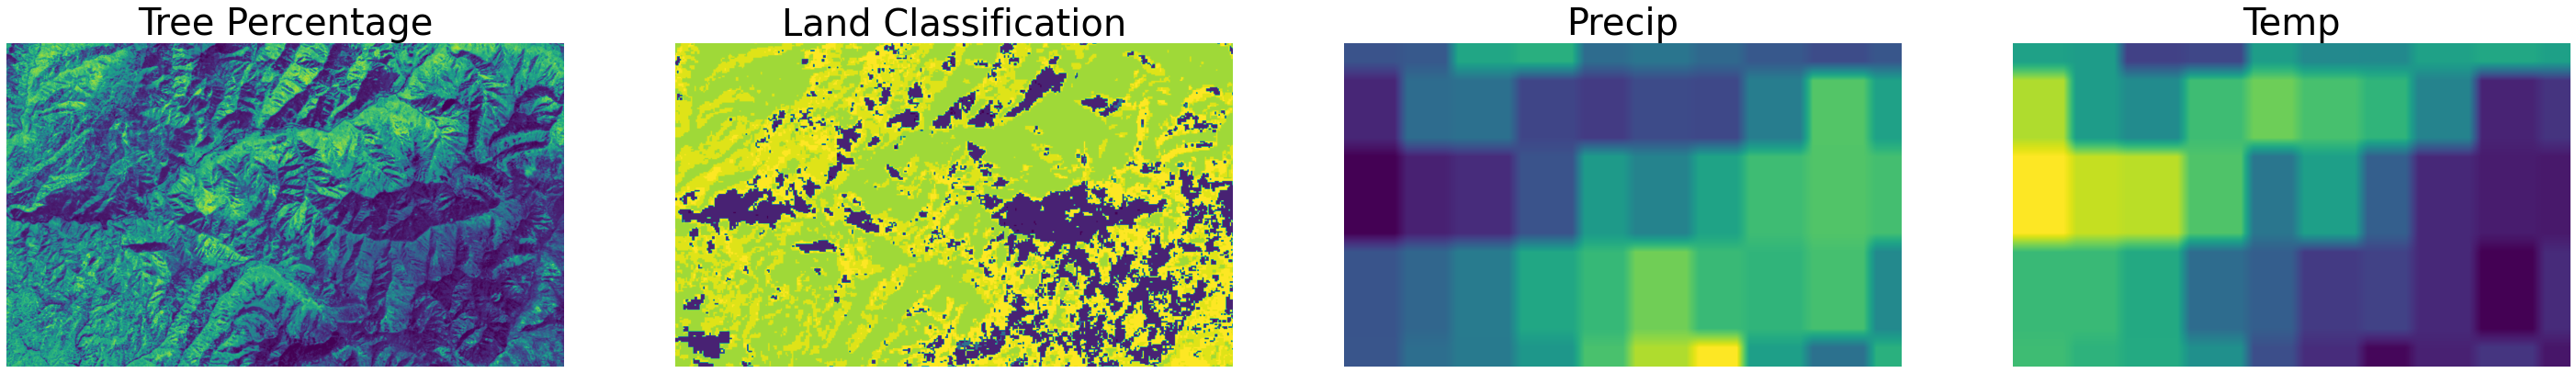

In [7]:
fig,axes = plt.subplots(1,4, figsize = (50,16))
axes[0].imshow(sub['trees'])
axes[1].imshow(sub['land_class'])
axes[2].imshow(sub['ppt_total'])
axes[3].imshow(sub['tmean'])

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.35, 0.05, 0.3])
# fig.colorbar(im, cax=cbar_ax)    
axes[0].title.set_text('Tree Percentage')
axes[1].title.set_text('Land Classification')
axes[2].title.set_text('Precip')
axes[3].title.set_text('Temp')
for ax in axes:
    ax.title.set_fontsize(40)
    ax.axis('off')
fig.savefig('../figures/4-panel-tree-land-prism.png')

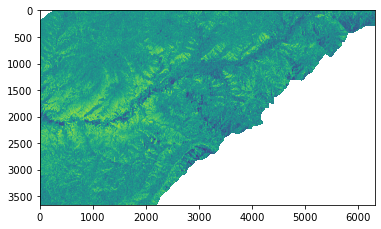

In [21]:
real = sub['VH-int-real']
imag = sub['VH-int-imaginary']
c = np.arctan(np.divide(imag, real, out = np.zeros_like(real), where = real != 0))
plt.imshow(c)

In [11]:
sub['VH-int-real']

<xarray.DataArray 'VH-int-real' (x: 3661, y: 6306)>
array([[ 0.      ,  0.      ,  0.      , ..., -0.016422, -0.016986, -0.002983],
       [ 0.      ,  0.      ,  0.      , ..., -0.004502, -0.005025, -0.006886],
       [ 0.      ,  0.      ,  0.      , ...,  0.009902,  0.017703,  0.009419],
       ...,
       [ 0.004018,  0.002097, -0.0026  , ...,  0.      ,  0.      ,  0.      ],
       [ 0.001779,  0.005327,  0.000745, ...,  0.      ,  0.      ,  0.      ],
       [-0.002573,  0.001328,  0.004379, ...,  0.      ,  0.      ,  0.      ]],
      dtype=float32)
Dimensions without coordinates: x, y

In [14]:
for name, values in sub.items():
    if name != 'dem':
        sub[name] = sub[name].where(sub['dem'] > 0)
sub['dem'] = sub['dem'].where(sub['dem'] > 0)

sub['easting'] = (('x','y'),np.degrees(np.cos(sub['aspect'].values)))
sub['northing'] = (('x','y'),np.degrees(np.sin(sub['aspect'].values)))

sub['inc'] = np.degrees(sub['inc'])

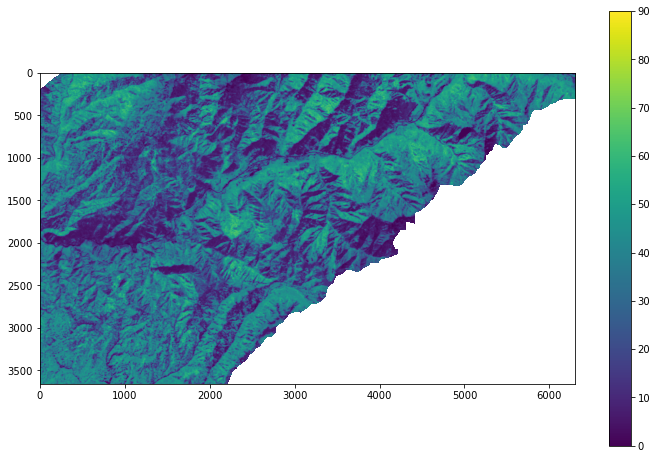

In [13]:
fig,axes = plt.subplots(figsize = (12,8))
plt.imshow(sub['trees'], vmin = 0, vmax = 90)
plt.colorbar()

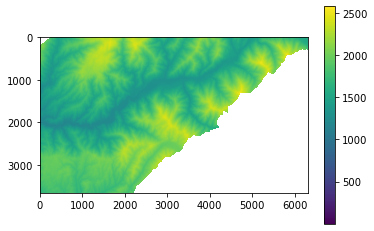

In [23]:
plt.imshow(sub['dem'])
plt.colorbar()

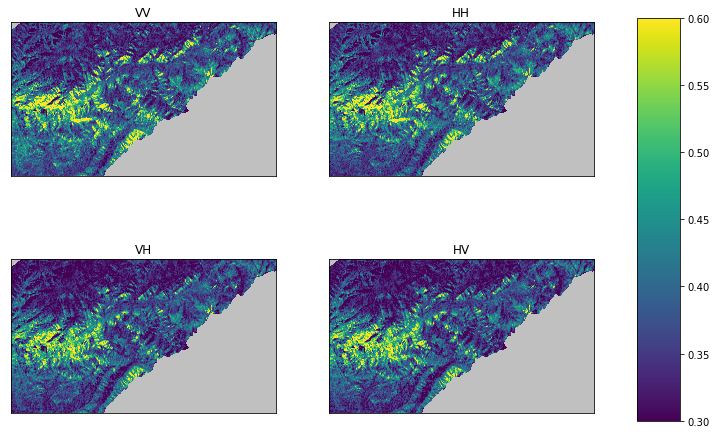

In [14]:
pols = ['VV','VH','HV','HH']
fig, axes = plt.subplots(ncols= 2, nrows = 2, figsize = (12,8),sharex='all', sharey='all')
i=0
j=0
vmin_val = 0.3
vmax_val = 0.6

for pol in pols:
    col = f'{pol}-cor'
    da = sub[col]
    
    im = axes[i,j].imshow(da, vmin = vmin_val, vmax = vmax_val)
    axes[i,j].get_xaxis().set_visible(False)
    axes[i,j].get_yaxis().set_visible(False)
    axes[i,j].set_facecolor('silver')
    axes[i,j].title.set_text(f'{pol}')

    #axes[i].colorbar()
    if j==0 and i == 0:
        i+=1
    elif j==0 and i == 1:
        j+=1
    else:
        i = 0
        
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)        
        
plt.savefig('../figures/cor-maps.png')
plt.show()

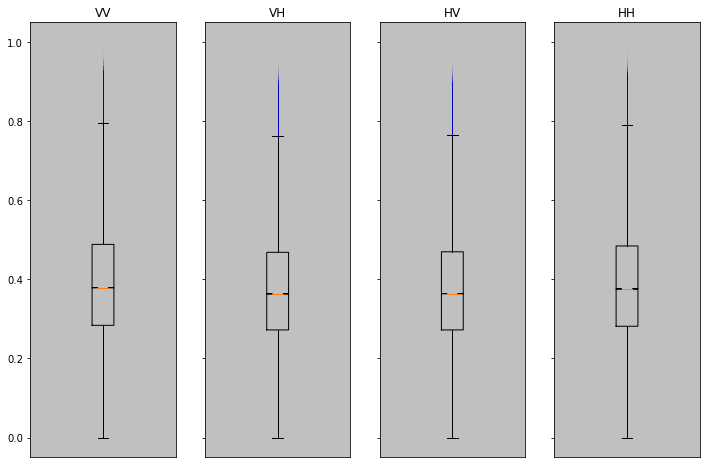

In [6]:
pols = ['VV','VH','HV','HH']
i = 0
fig, axes = plt.subplots(ncols= 4, figsize = (12,8),sharex='all', sharey='all')
flierprops = dict(marker='*', markerfacecolor='blue', markersize=1,
                  markeredgecolor='none', alpha = 0.0059)
for pol in pols:
    col = f'{pol}-cor'
    da = sub[col].values
    axes[i].boxplot(da[~np.isnan(da)], notch = True, showfliers= True, flierprops = flierprops)
    axes[i].set_facecolor('silver')
    axes[i].get_xaxis().set_visible(False)
    axes[i].title.set_text(f'{pol}')
    i += 1
plt.savefig('../figures/cor-boxplots.png')
plt.show()

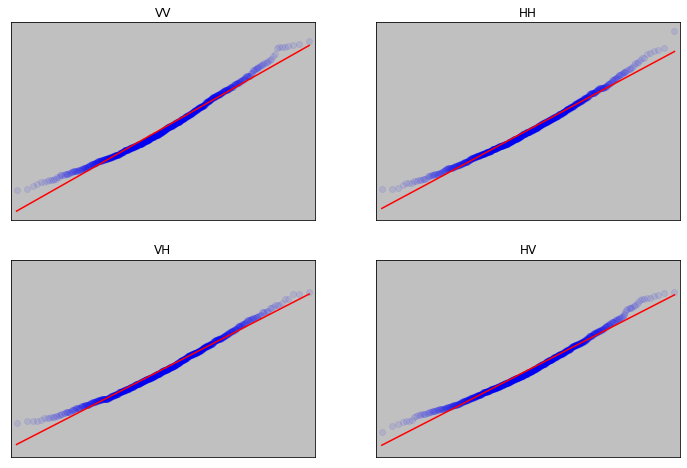

In [23]:
pols = ['VV','VH','HV','HH']
fig, axes = plt.subplots(ncols= 2, nrows = 2, figsize = (12,8),sharex='all', sharey='all')
i=0
j=0
vmin_val = 0.3
vmax_val = 0.6

for pol in pols:
    col = f'{pol}-cor'
    da = sub[col].values.ravel()
    da = da[~np.isnan(da)]
    
    df = pd.DataFrame()
    df['cor'] = da
    sm.qqplot(df.sample(1000).cor, line ='s', ax = axes[i][j])
    # Grab the lines with blue dots
    dots = fig.findobj(lambda x: hasattr(x, 'get_color') and x.get_color() == 'b')

    [d.set_alpha(0.08) for d in dots]
    axes[i,j].get_xaxis().set_visible(False)
    axes[i,j].get_yaxis().set_visible(False)
    axes[i,j].set_facecolor('silver')
    axes[i,j].title.set_text(f'{pol}')

    #axes[i].colorbar()
    if j==0 and i == 0:
        i+=1
    elif j==0 and i == 1:
        j+=1
    else:
        i = 0
                
plt.savefig('../figures/cor-QQ.png')
plt.show()

(array([ 18.,  65., 184., 198., 222., 153.,  89.,  42.,  20.,   9.]),
 array([0.03707038, 0.11956088, 0.20205139, 0.2845419 , 0.3670324 ,
        0.4495229 , 0.5320134 , 0.6145039 , 0.6969944 , 0.7794849 ,
        0.86197543], dtype=float32),
 <BarContainer object of 10 artists>)

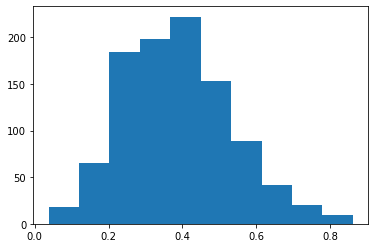

In [19]:
plt.hist(df.cor.sample(1000))

100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


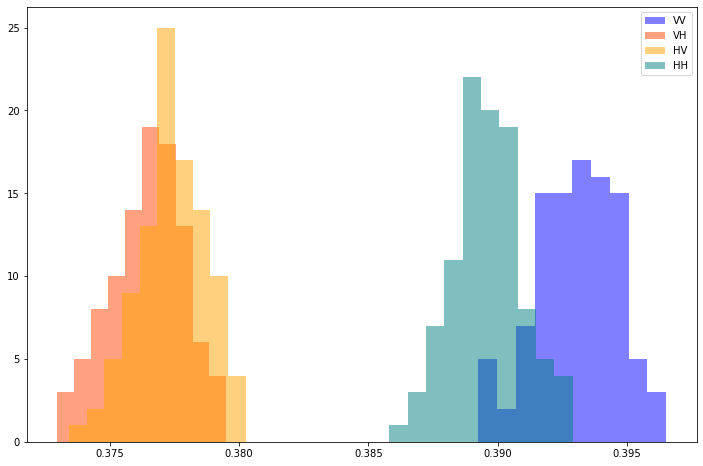

In [8]:
col_dic = {'VV':'blue','VH':'orangered','HV':'orange','HH':'teal'}
pols = ['VV','VH','HV','HH']

nboots = 100
fig, axes = plt.subplots(ncols= 1, nrows = 1, figsize = (12,8))

for pol in pols:
    col = f'{pol}-cor'
    da = sub[col].values
    
    df = pd.DataFrame({'x':da[~np.isnan(da)]})
    means = np.zeros(nboots)
    for boot in tqdm(range(nboots)):
        samp = df.sample(10000)

        means[boot] = samp.x.mean()

    axes.hist(means, alpha = 0.5, color = col_dic[pol], label = pol, bins = 10)
plt.legend()
plt.savefig(f'../figures/cor-mc-hist.png')
plt.show()

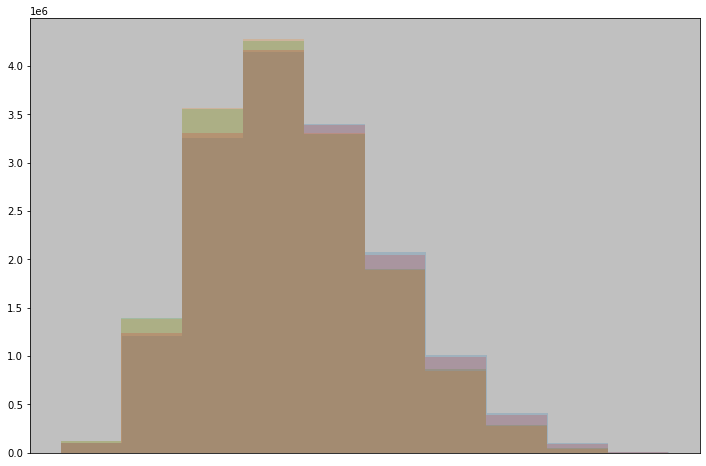

In [9]:
pols = ['VV','VH','HV','HH']
i = 0
fig, axes = plt.subplots(ncols= 1, figsize = (12,8),sharex='all', sharey='all')
flierprops = dict(marker='*', markerfacecolor='blue', markersize=1,
                  markeredgecolor='none', alpha = 0.0059)
for pol in pols:
    col = f'{pol}-cor'
    da = sub[col].values
    axes.hist(da[~np.isnan(da)], alpha = 0.2)
axes.set_facecolor('silver')
axes.get_xaxis().set_visible(False)

plt.show()

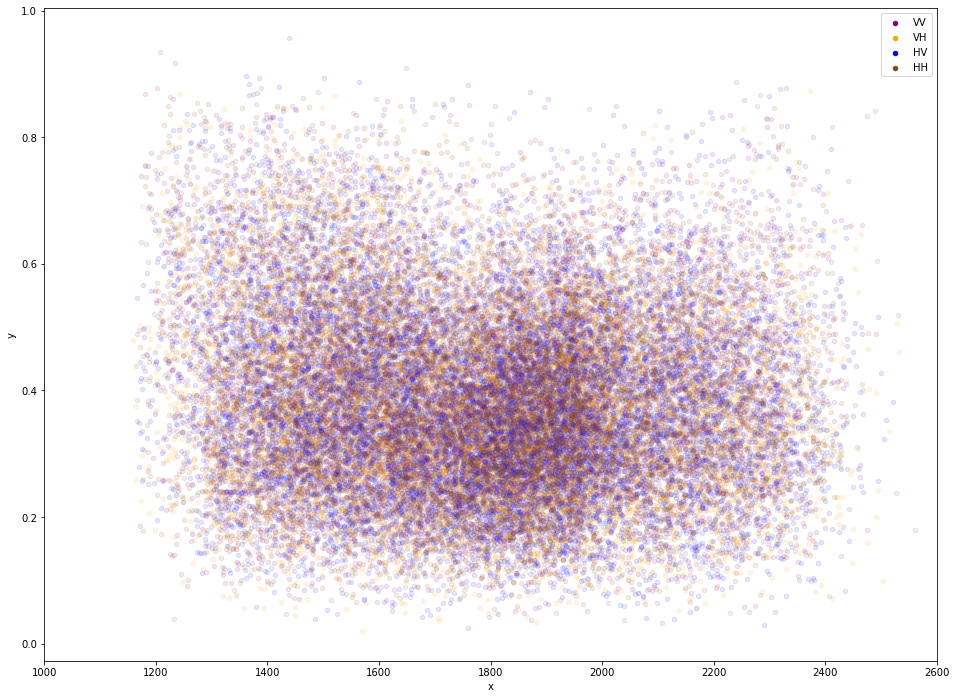

In [10]:
pols = ['VV','VH','HV','HH']
col_dic = {'VV':'purple','VH':'orange','HV':'blue','HH':'saddlebrown'}

fig,ax = plt.subplots(figsize = (16,12))
for pol in pols:
    col = f'{pol}-cor'
    da = sub[col].values
    elev = sub['dem'].values
    df = pd.DataFrame({'x':elev[~np.isnan(elev)], 'y':da[~np.isnan(da)]})
    samp = df.sample(10000)


    samp.plot(x = 'x', y = 'y',kind = 'scatter', alpha = 0.1, label = f'{pol}',ax = ax, color = col_dic[pol])

plt.xlim(1000,2600)
leg = plt.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.show()

In [6]:
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

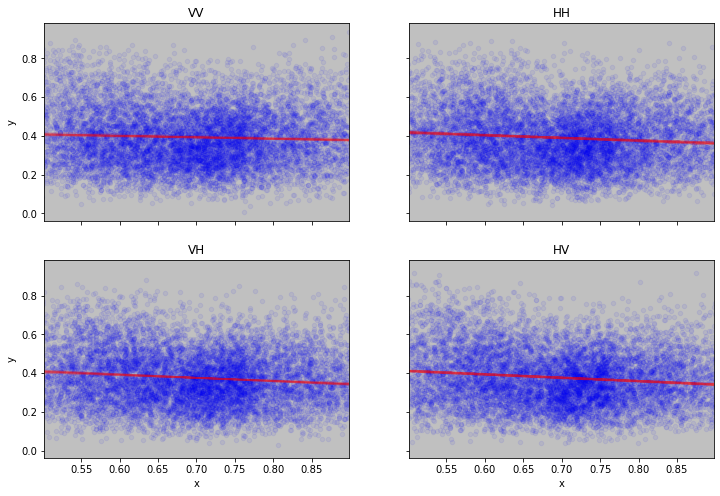

In [9]:
pols = ['VV','VH','HV','HH']
fig, axes = plt.subplots(ncols= 2, nrows = 2, figsize = (12,8),sharex='all', sharey='all')
i=0
j=0
nboots = 10
for pol in pols:
    col = f'{pol}-cor'
    da = sub[col].values
    elev = sub['dem'].values
    df = pd.DataFrame({'x':elev[~np.isnan(elev)], 'y':da[~np.isnan(da)]})
    
    ##normalize 0-1
    #df.x = normalize_data(df.x)
    
    samp = df.sample(10000)

    ax = axes[i,j]
    samp.plot(x = 'x', y = 'y',kind = 'scatter', alpha = 0.06, ax = ax, color = 'blue') 
    
    lr = LinearRegression()
    for boot in range(nboots):
        samp = df.sample(10000)

        lr.fit(samp['x'].values.reshape(-1, 1), samp['y'].values.reshape(-1, 1))
        Y_pred = lr.predict(samp['x'].values.reshape(-1, 1))
        ax.plot(samp['x'], Y_pred, color='red', alpha = 0.1)
    #ax.text(s = f'{lr.coef_}x + {lr.intercept_}', x = 1100, y = 0.6)
        
    quants = np.quantile(df.x,[0.025,0.975])
    ax.set_xlim(quants[0],quants[1])
    ax.set_facecolor('silver')
    ax.title.set_text(f'{pol}')


    if j==0 and i == 0:
        i+=1
    elif j==0 and i == 1:
        j+=1
    else:
        i = 0
        
plt.savefig('../figures/elev-cor-scats.png')
plt.show()

100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


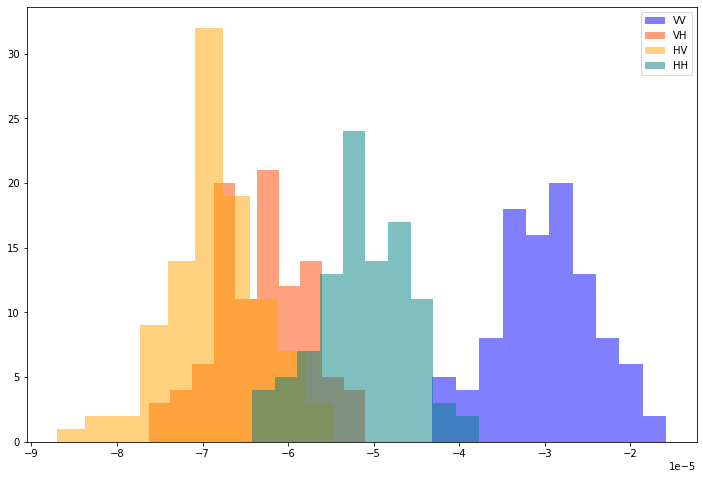

In [12]:
col_dic = {'VV':'blue','VH':'orangered','HV':'orange','HH':'teal'}

nboots = 100
fig, axes = plt.subplots(ncols= 1, nrows = 1, figsize = (12,8))

for pol in pols:
    col = f'{pol}-cor'
    da = sub[col].values
    elev = sub['dem'].values
    df = pd.DataFrame({'x':elev[~np.isnan(elev)], 'y':da[~np.isnan(da)]})
    df.x = normalize_data(df.x)

    lr = LinearRegression()
    coefs = np.zeros(nboots)
    for boot in tqdm(range(nboots)):
        samp = df.sample(10000)

        lr.fit(samp['x'].values.reshape(-1, 1), samp['y'].values.reshape(-1, 1))
        coefs[boot] = lr.coef_

    axes.hist(coefs, alpha = 0.5, color = col_dic[pol], label = pol)
plt.legend()
plt.savefig(f'../figures/elev-cor-mc-hist.png')
plt.show()

inc


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


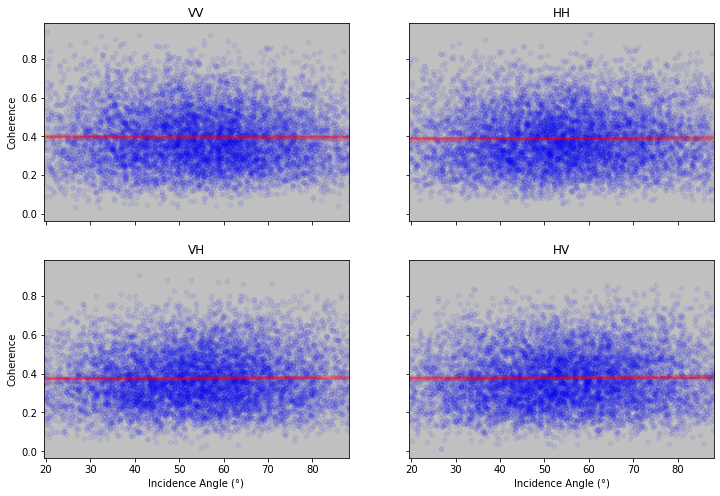

trees


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


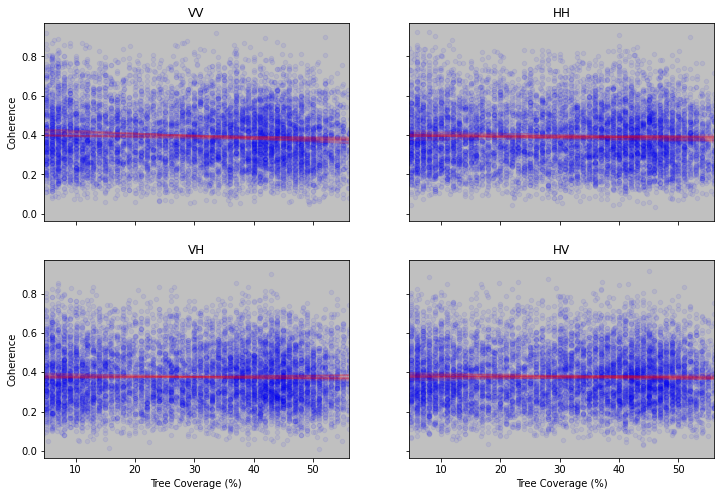

slope


100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


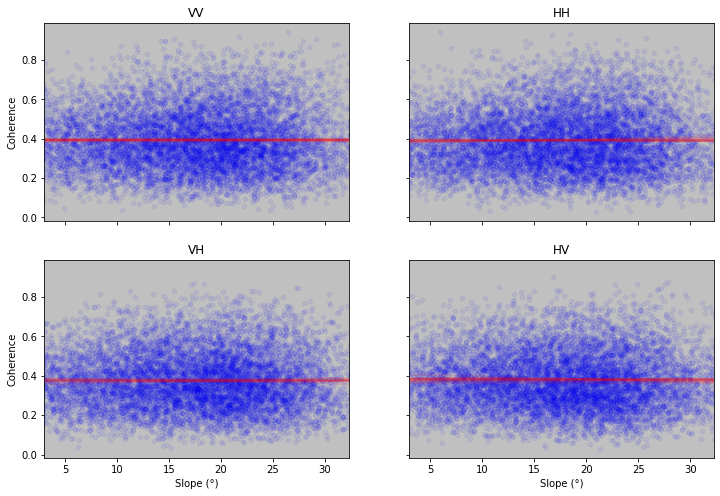

easting


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


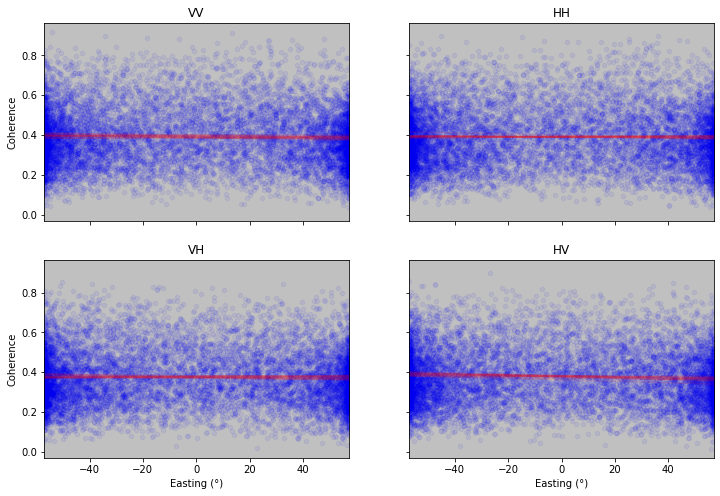

northing


100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


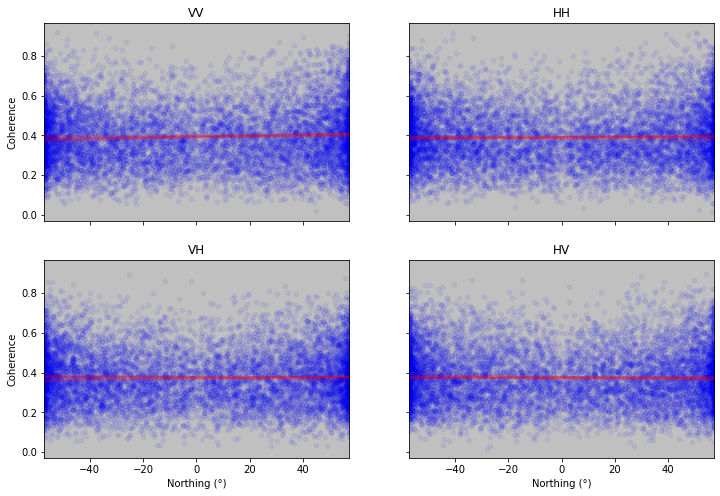

focal_var


100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


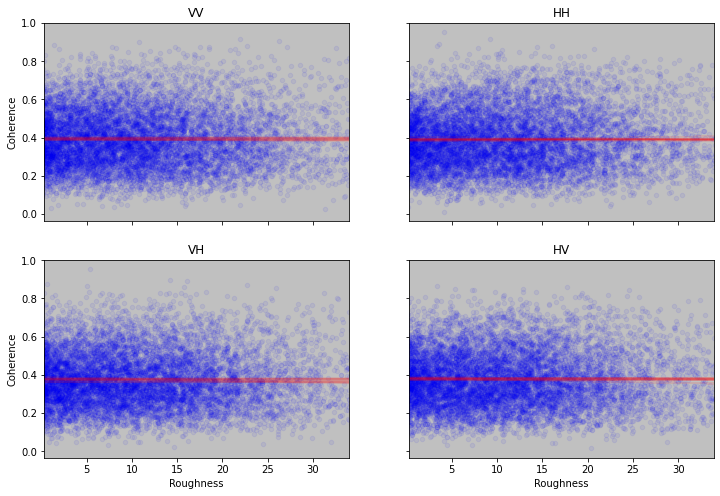

ppt_total


100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


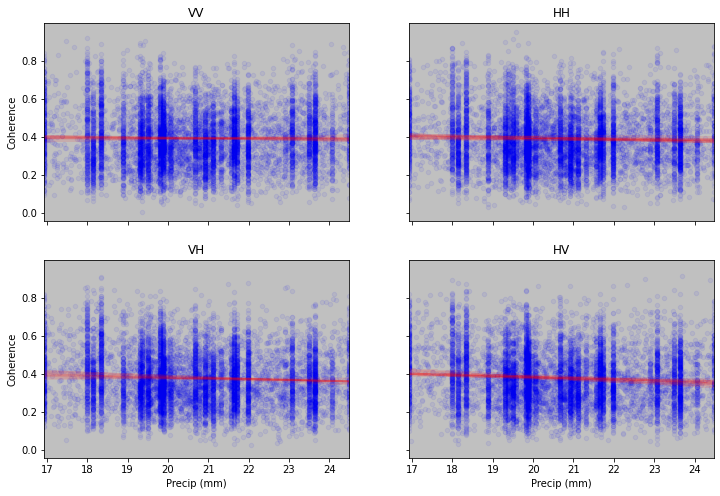

tmean


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


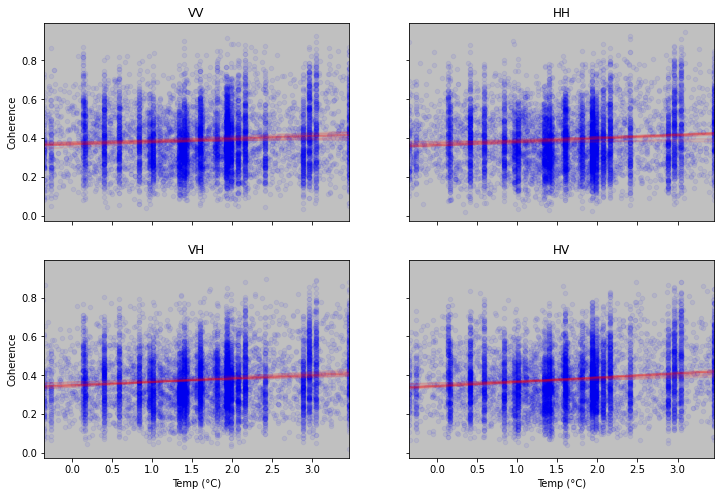

In [6]:
pols = ['VV','VH','HV','HH']

cols = ['inc','trees','slope','easting','northing','focal_var','ppt_total','tmean']
xlab = {'inc': 'Incidence Angle (°)','trees': 'Tree Coverage (%)','slope':'Slope (°)','easting':'Easting (°)','northing':'Northing (°)','focal_var':'Roughness','ppt_total':'Precip (mm)','tmean':'Temp (°C)'}

nboots = 10
for col_compare in cols:
    print(col_compare)
    fig, axes = plt.subplots(ncols= 2, nrows = 2, figsize = (12,8),sharex='all', sharey='all')

    i=0
    j=0
    for pol in pols:
        col = f'{pol}-cor'
        da = sub[col].values
        da_2 = sub[col_compare].values
        df = pd.DataFrame({'x':da_2[~np.isnan(da_2)], 'y':da[~np.isnan(da)]})
        samp = df.sample(10000)

        ax = axes[i,j]
        samp.plot(x = 'x', y = 'y',kind = 'scatter', alpha = 0.06, ax = ax, color = 'blue') 

        lr = LinearRegression()
        for boot in tqdm(range(nboots)):
            samp = df.sample(1000)

            lr.fit(samp['x'].values.reshape(-1, 1), samp['y'].values.reshape(-1, 1))
            Y_pred = lr.predict(samp['x'].values.reshape(-1, 1))
            ax.plot(samp['x'], Y_pred, color='red', alpha = 0.1)    
        quants = np.quantile(df.x,[0.025,0.975])
        ax.set_xlim(quants[0],quants[1])
        ax.set_facecolor('silver')
        ax.title.set_text(f'{pol}')

        ax.set_xlabel(xlab[col_compare])
        ax.set_ylabel('Coherence')
        
        if j==0 and i == 0:
            i+=1
        elif j==0 and i == 1:
            j+=1
        else:
            i = 0
    plt.savefig(f'../figures/{col_compare}-cor-scats.png')
    plt.show()


  0%|          | 0/100 [00:00<?, ?it/s]

inc


100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


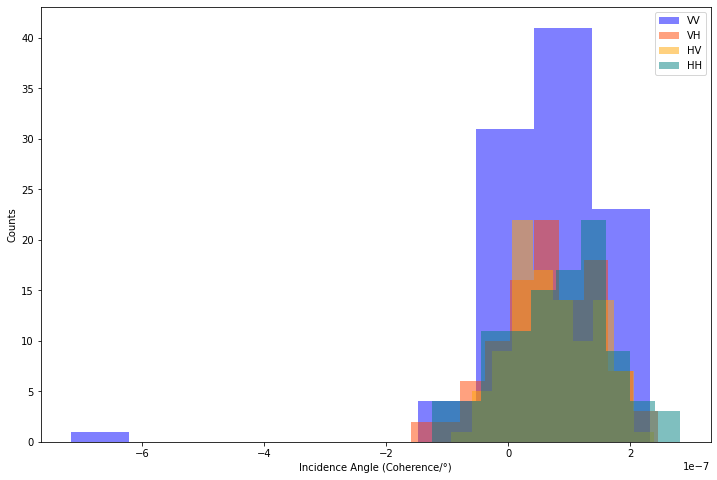


  0%|          | 0/100 [00:00<?, ?it/s]

trees


100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


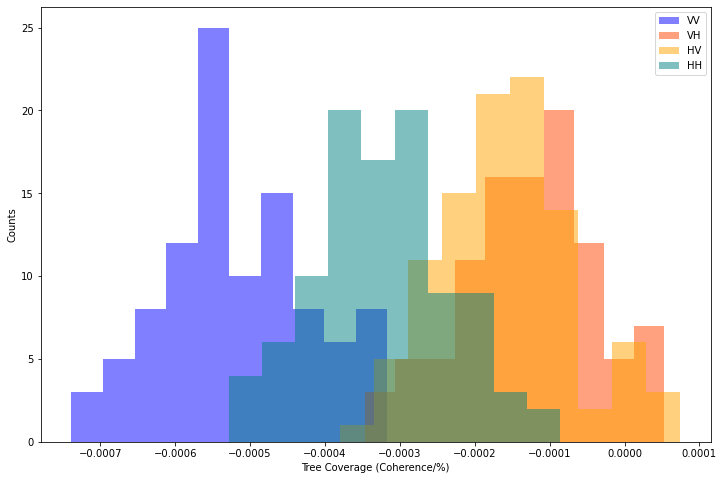


  0%|          | 0/100 [00:00<?, ?it/s]

slope


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


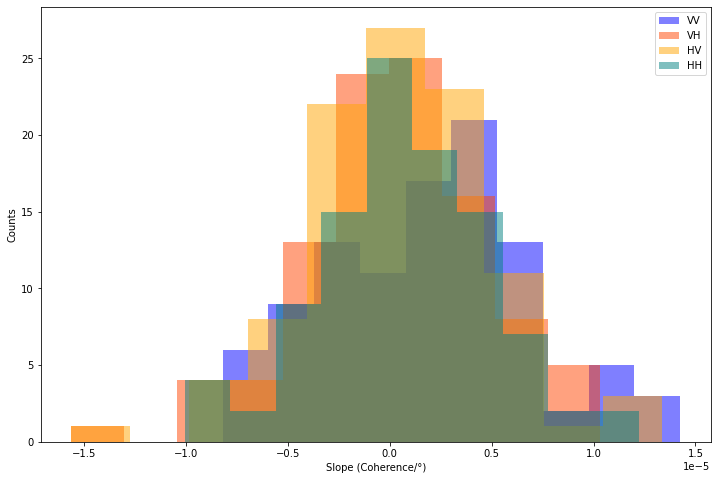


  0%|          | 0/100 [00:00<?, ?it/s]

easting


100%|██████████| 100/100 [01:13<00:00,  1.35it/s]


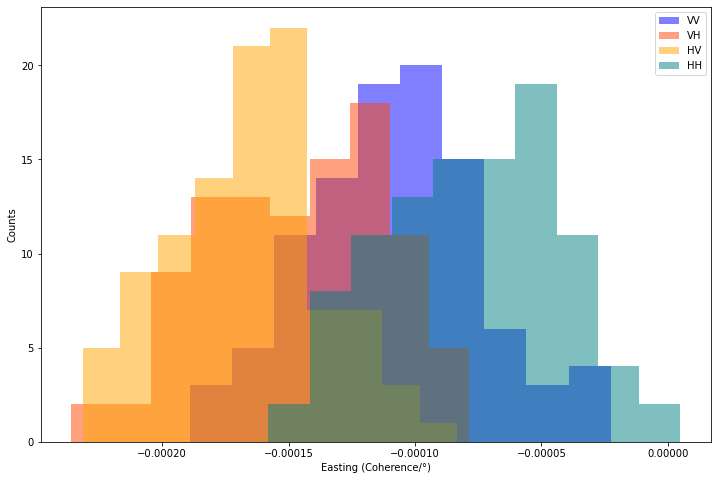


  0%|          | 0/100 [00:00<?, ?it/s]

northing


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


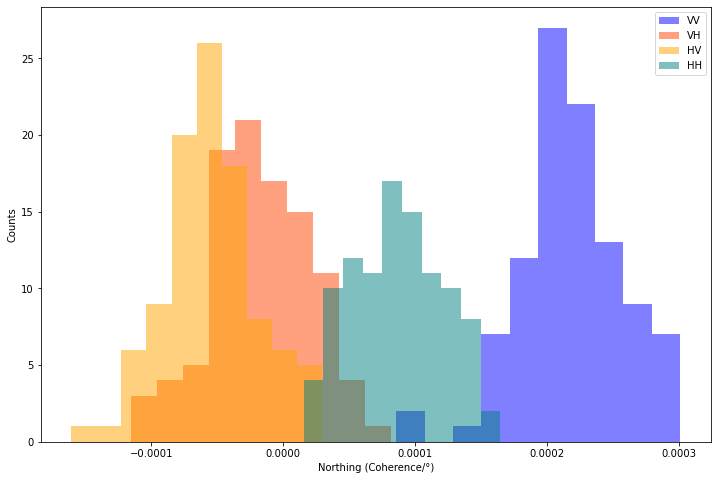


  0%|          | 0/100 [00:00<?, ?it/s]

focal_var


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


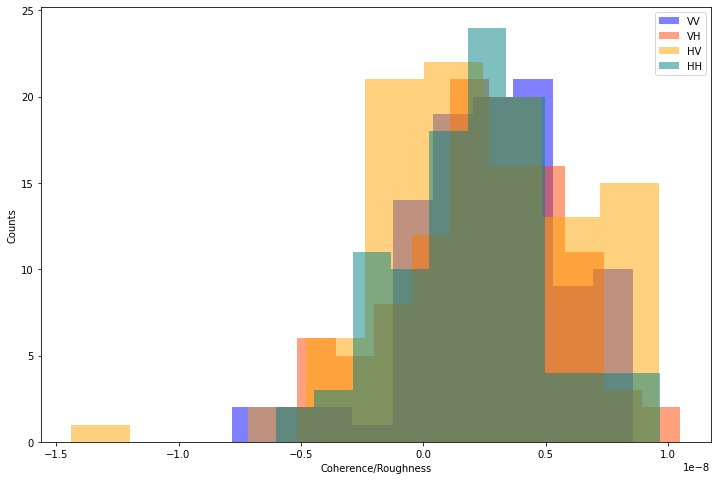


  0%|          | 0/100 [00:00<?, ?it/s]

ppt_total


100%|██████████| 100/100 [01:13<00:00,  1.36it/s]


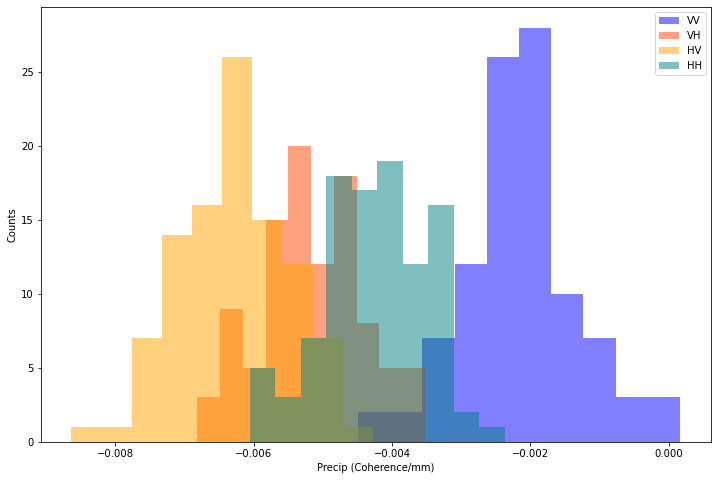


  0%|          | 0/100 [00:00<?, ?it/s]

tmean


100%|██████████| 100/100 [01:16<00:00,  1.30it/s]


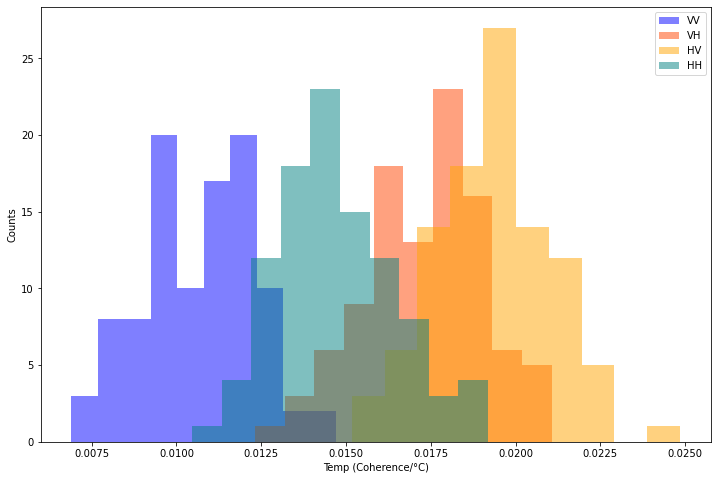

In [13]:
col_dic = {'VV':'blue','VH':'orangered','HV':'orange','HH':'teal'}
cols = ['inc','trees','slope','easting','northing','focal_var','ppt_total','tmean']
xlab = {'inc': 'Incidence Angle (Coherence/°)','trees': 'Tree Coverage (Coherence/%)','slope':'Slope (Coherence/°)','easting':'Easting (Coherence/°)','northing':'Northing (Coherence/°)','focal_var':'Coherence/Roughness','ppt_total':'Precip (Coherence/mm)','tmean':'Temp (Coherence/°C)'}

nboots = 100

for col_compare in cols:
    print(col_compare)
    fig, axes = plt.subplots(ncols= 1, nrows = 1, figsize = (12,8))

    for pol in pols:
        col = f'{pol}-cor'
        da = sub[col].values
        da_2 = sub[col_compare].values
        df = pd.DataFrame({'x':da_2[~np.isnan(da_2)], 'y':da[~np.isnan(da)]})

        lr = LinearRegression()
        coefs = np.zeros(nboots)
        for boot in tqdm(range(nboots)):
            samp = df.sample(10000)

            lr.fit(samp['x'].values.reshape(-1, 1), samp['y'].values.reshape(-1, 1))
            coefs[boot] = lr.coef_

        axes.hist(coefs, alpha = 0.5, color = col_dic[pol], label = pol)
        axes.set_xlabel(xlab[col_compare])
        axes.set_ylabel('Counts')

    plt.legend()
    plt.savefig(f'../figures/{col_compare}-cor-mc-hist.png')
    plt.show()

dem


100%|██████████| 200/200 [03:39<00:00,  1.10s/it]


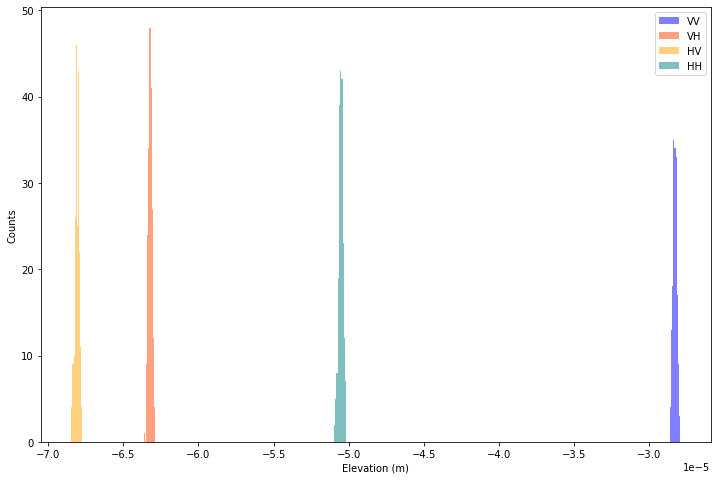

In [11]:
pols = ['VV','VH','HV','HH']

col_dic = {'VV':'blue','VH':'orangered','HV':'orange','HH':'teal'}
cols = ['trees','northing','ppt_total','tmean']
cols = ['dem']
xlab = {'dem':'Elevation (m)','inc': 'Incidence Angle (Coherence/°)','trees': 'Tree Coverage (Coherence/%)','slope':'Slope (Coherence/°)','easting':'Easting (Coherence/°)','northing':'Northing (Coherence/°)','focal_var':'Coherence/Roughness','ppt_total':'Precip (Coherence/mm)','tmean':'Temp (Coherence/°C)'}

nboots = 200

for col_compare in cols:
    print(col_compare)
    fig, axes = plt.subplots(ncols= 1, nrows = 1, figsize = (12,8))

    for pol in pols:
        col = f'{pol}-cor'
        da = sub[col].values
        da_2 = sub[col_compare].values
        df = pd.DataFrame({'x':da_2[~np.isnan(da_2)], 'y':da[~np.isnan(da)]})

        lr = LinearRegression()
        coefs = np.zeros(nboots)
        for boot in tqdm(range(nboots)):
            samp = df.sample(len(df), replace = True)

            lr.fit(samp['x'].values.reshape(-1, 1), samp['y'].values.reshape(-1, 1))
            coefs[boot] = lr.coef_

        axes.hist(coefs, alpha = 0.5, color = col_dic[pol], label = pol)
        axes.set_xlabel(xlab[col_compare])
        axes.set_ylabel('Counts')

    plt.legend()
    plt.savefig(f'../figures/{col_compare}-cor-mc-hist.png')
    plt.show()

In [8]:
df

x         y
0         0.736364  0.078533
1         0.736135  0.534385
2         0.735907  0.525406
3         0.735676  0.404686
4         0.735655  0.325908
...            ...       ...
15721908  0.727111  0.160454
15721909  0.726960  0.158948
15721910  0.726862  0.138434
15721911  0.726763  0.205677
15721912  0.726663  0.300454

[15721913 rows x 2 columns]

land_class
           coh
cat           
20.0     32253
30.0   1804713
50.0      1428
60.0      7272
90.0       784
111.0  8027139
114.0     2184
115.0     5994
116.0    17815
121.0  4242147
124.0      630
125.0      406
126.0  1579148


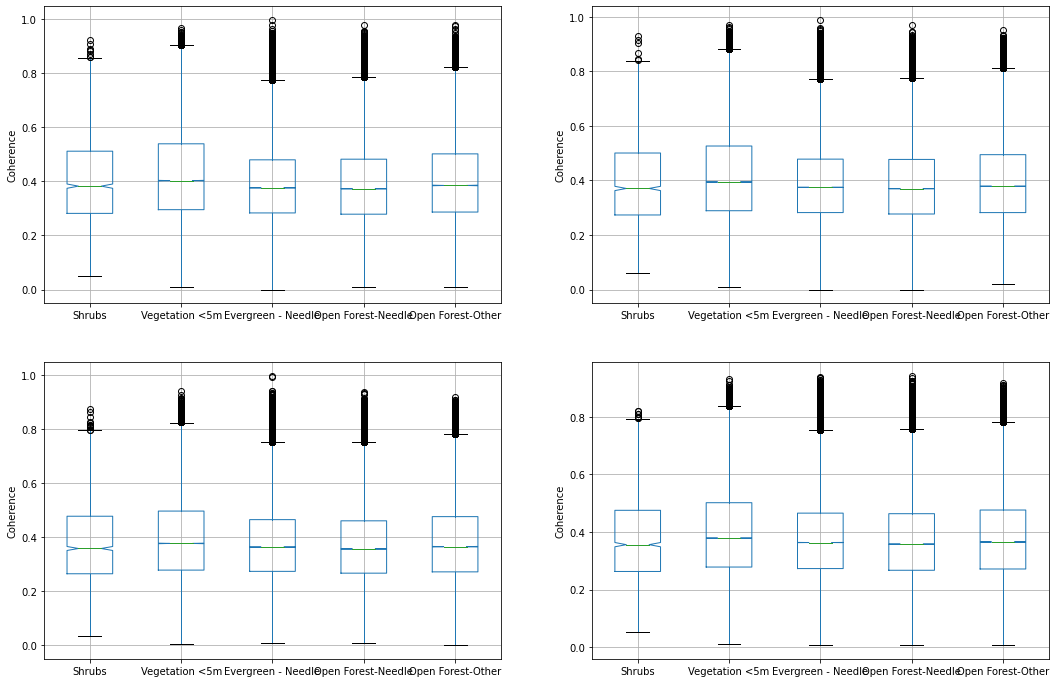

In [55]:
cover_descriptions = {20.:'Shrubs',30.:'Vegetation <5m', 50.:'Urban', 60.:'Exposed Soil',
                     90.: 'Wetland', 111.:'Evergreen - Needle', 114.:'Deciduous',
                     115.:'Forest-Mixed',116.:'Forest-Other',121.:'Open Forest-Needle',
                     124.:'Open Forest-Broad',125.:'Open Forest-Mixed',126.:'Open Forest-Other'}

pols = ['VV','VH','HV','HH']

col_dic = {'VV':'blue','VH':'orangered','HV':'orange','HH':'teal'}
cols = ['land_class']
count = True

for col_compare in cols:
    print(col_compare)
    fig, axes = plt.subplots(ncols= 2, nrows = 2, figsize = (18,12))
    i=0
    j=0

    for pol in pols:
        ax = axes[i,j]
        col = f'{pol}-cor'
        da = sub[col].values
        da_2 = sub[col_compare].values
        df = pd.DataFrame({'cat':da_2[~np.isnan(da_2)], 'coh':da[~np.isnan(da)]})
        if count:
            print(df.groupby('cat').count())
            count = False
        df_most = df[(df.cat == 20.) | (df.cat == 30.) | (df.cat == 111.) | (df.cat == 121.) | (df.cat == 126.)]
        samp = df_most.sample(int(1e6))
        samp.groupby('cat').boxplot(subplots=False, column = 'coh',notch = True,ax = ax)
        ax.set_ylabel('Coherence')

        labels = [item.get_text() for item in ax.get_xticklabels()]
        labels = [cover_descriptions[float(label.replace('(','').replace(', coh)',''))] for label in labels]

        ax.set_xticklabels(labels)
        
        if j==0 and i == 0:
            i+=1
        elif j==0 and i == 1:
            j+=1
        else:
            i = 0
    plt.savefig(f'../figures/{col_compare}-cor-box.png')
    plt.show()

land_class
           coh
cat           
20.0     32253
30.0   1804713
50.0      1428
60.0      7272
90.0       784
111.0  8027139
114.0     2184
115.0     5994
116.0    17815
121.0  4242147
124.0      630
125.0      406
126.0  1579148


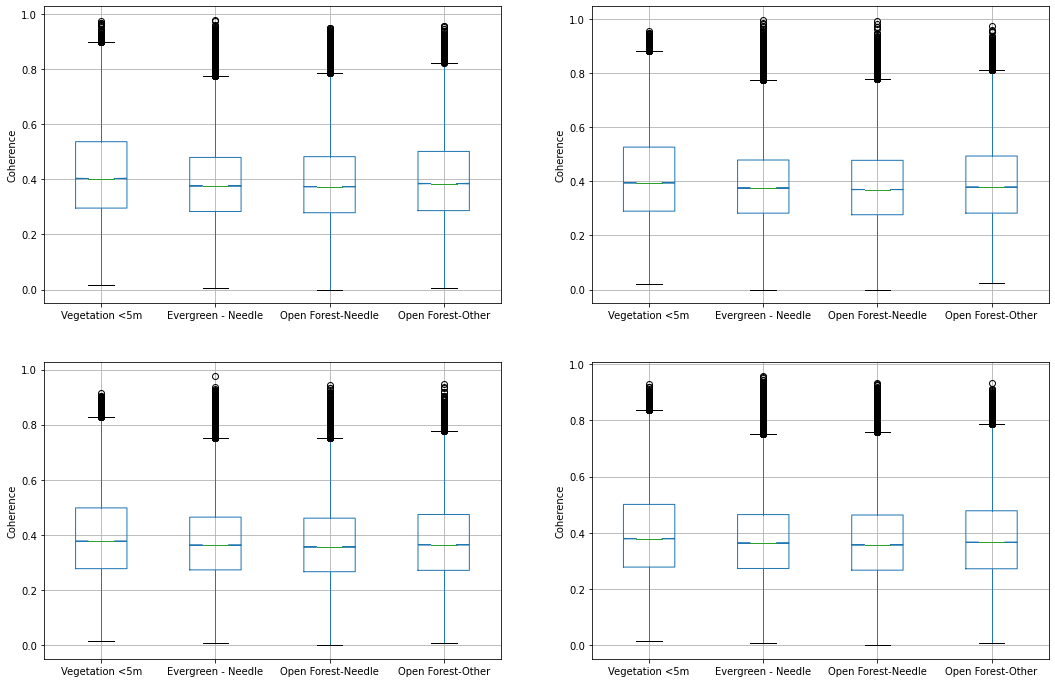

In [44]:
cover_descriptions = {20.:'Shrubs',30.:'Vegetation <5m', 50.:'Urban', 60.:'Exposed Soil',
                     90.: 'Wetland', 111.:'Evergreen - Needle', 114.:'Deciduous',
                     115.:'Forest-Mixed',116.:'Forest-Other',121.:'Open Forest-Needle',
                     124.:'Open Forest-Broad',125.:'Open Forest-Mixed',126.:'Open Forest-Other'}

pols = ['VV','VH','HV','HH']

col_dic = {'VV':'blue','VH':'orangered','HV':'orange','HH':'teal'}
cols = ['land_class']
count = True

for col_compare in cols:
    print(col_compare)
    fig, axes = plt.subplots(ncols= 2, nrows = 2, figsize = (18,12))
    i=0
    j=0

    for pol in pols:
        ax = axes[i,j]
        col = f'{pol}-cor'
        da = sub[col].values
        da_2 = sub[col_compare].values
        df = pd.DataFrame({'cat':da_2[~np.isnan(da_2)], 'coh':da[~np.isnan(da)]})
        if count:
            print(df.groupby('cat').count())
            count = False
        df_most = df[(df.cat == 30.) | (df.cat == 111.) | (df.cat == 121.) | (df.cat == 126.)]
        samp = df_most.sample(int(1e6))
        samp.groupby('cat').boxplot(subplots=False, column = 'coh',notch = True,ax = ax)
        ax.set_ylabel('Coherence')

        labels = [item.get_text() for item in ax.get_xticklabels()]
        labels = [cover_descriptions[float(label.replace('(','').replace(', coh)',''))] for label in labels]

        ax.set_xticklabels(labels)
        
        if j==0 and i == 0:
            i+=1
        elif j==0 and i == 1:
            j+=1
        else:
            i = 0
    plt.savefig(f'../figures/{col_compare}-cor-box.png')
    plt.show()

land_forms
          coh
cat          
11.0   249855
12.0   463448
13.0    74473
14.0   149431
15.0     7765
21.0  2138247
22.0  3227224
23.0  1500502
24.0      648
31.0  1577765
32.0  2547442
33.0  1384380
34.0     7788
41.0  1822904
42.0   570041


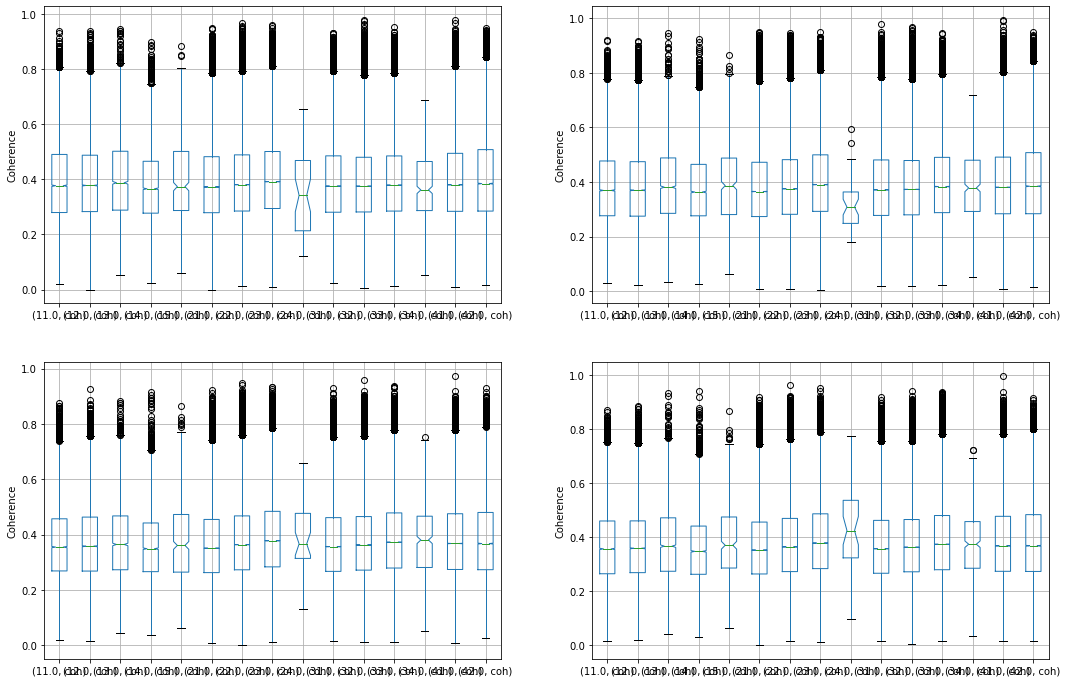

In [58]:
pols = ['VV','VH','HV','HH']

col_dic = {'VV':'blue','VH':'orangered','HV':'orange','HH':'teal'}
cols = ['land_forms']
count = True

for col_compare in cols:
    print(col_compare)
    fig, axes = plt.subplots(ncols= 2, nrows = 2, figsize = (18,12))
    i=0
    j=0

    for pol in pols:
        ax = axes[i,j]
        col = f'{pol}-cor'
        da = sub[col].values
        da_2 = sub[col_compare].values
        df = pd.DataFrame({'cat':da_2[~np.isnan(da_2)], 'coh':da[~np.isnan(da)]})
        if count:
            print(df.groupby('cat').count())
            count = False
        samp = df.sample(int(1e6))
        samp.groupby('cat').boxplot(subplots=False, column = 'coh',notch = True,ax = ax)
        ax.set_ylabel('Coherence')
        
        if j==0 and i == 0:
            i+=1
        elif j==0 and i == 1:
            j+=1
        else:
            i = 0
    plt.savefig(f'../figures/{col_compare}-cor-box.png')
    plt.show()